In [1]:
import argparse

import torch

from accelerate import Accelerator, DeepSpeedPlugin

from accelerate import DistributedDataParallelKwargs

from torch import nn, optim

from torch.optim import lr_scheduler

from tqdm import tqdm



from models import Autoformer, DLinear, TimeLLM



#from data_provider.data_factory import data_provider

import time

import random

import numpy as np

import os



os.environ['CURL_CA_BUNDLE'] = ''

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"



from utils.tools import del_files, EarlyStopping, adjust_learning_rate, vali, load_content


fix_seed = 2021

random.seed(fix_seed)

torch.manual_seed(fix_seed)

np.random.seed(fix_seed)

/home/user/miniconda/envs/gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-05-21 14:10:16,043] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
ddp_kwargs = DistributedDataParallelKwargs(find_unused_parameters=True)

deepspeed_plugin = DeepSpeedPlugin(hf_ds_config='./ds_config_zero2.json')

accelerator = Accelerator(kwargs_handlers=[ddp_kwargs], deepspeed_plugin=deepspeed_plugin)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("dataset/traffic.csv")

In [5]:
df

,date,0,1,2,3,4,5,6,7,8,...,852,853,854,855,856,857,858,859,860,OT
0,2016-07-01 02:00:00,0.0048,0.0146,0.0289,0.0142,0.0064,0.0232,0.0162,0.0242,0.0341,...,0.0051,0.0051,0.0074,0.0079,0.0051,0.0051,0.0339,0.0051,0.0100,0.0121
1,2016-07-01 03:00:00,0.0072,0.0148,0.0350,0.0174,0.0084,0.0240,0.0201,0.0338,0.0434,...,0.0036,0.0036,0.0107,0.0058,0.0036,0.0036,0.0348,0.0036,0.0087,0.0136
2,2016-07-01 04:00:00,0.0040,0.0101,0.0267,0.0124,0.0049,0.0170,0.0127,0.0255,0.0332,...,0.0030,0.0030,0.0043,0.0050,0.0030,0.0030,0.0327,0.0030,0.0061,0.0107
3,2016-07-01 05:00:00,0.0039,0.0060,0.0218,0.0090,0.0029,0.0118,0.0088,0.0163,0.0211,...,0.0033,0.0033,0.0019,0.0052,0.0033,0.0033,0.0292,0.0033,0.0040,0.0071
4,2016-07-01 06:00:00,0.0042,0.0055,0.0191,0.0082,0.0024,0.0095,0.0064,0.0087,0.0144,...,0.0049,0.0049,0.0011,0.0071,0.0049,0.0049,0.0264,0.0049,0.0040,0.0039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,2018-07-01 21:00:00,0.0342,0.0332,0.1378,0.0559,0.0165,0.0386,0.0457,0.0687,0.0716,...,0.0139,0.0179,0.0278,0.0280,0.0227,0.0375,0.0142,0.0201,0.0341,0.0429
17540,2018-07-01 22:00:00,0.0285,0.0253,0.0542,0.0485,0.0131,0.0331,0.0372,0.0569,0.0669,...,0.0116,0.0155,0.0201,0.0267,0.0207,0.0320,0.0122,0.0163,0.0306,0.0363
17541,2018-07-01 23:00:00,0.0276,0.0257,0.0551,0.0474,0.0121,0.0326,0.0381,0.0566,0.0675,...,0.0109,0.0142,0.0208,0.0252,0.0189,0.0287,0.0123,0.0152,0.0292,0.0325
17542,2018-07-02 00:00:00,0.0232,0.0229,0.0496,0.0435,0.0119,0.0297,0.0361,0.0517,0.0598,...,0.0092,0.0124,0.0219,0.0215,0.0169,0.0258,0.0096,0.0130,0.0252,0.0279


TypeError: unhashable type: 'numpy.ndarray'

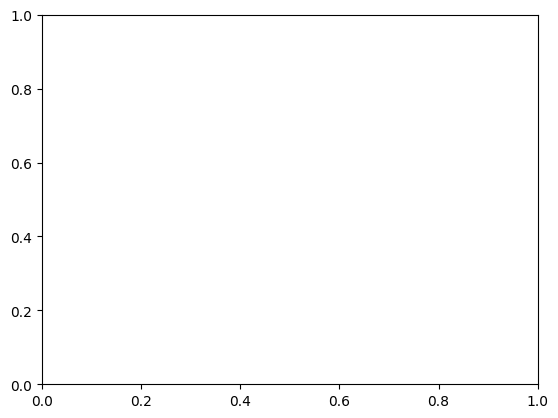

In [4]:
plt.plot(df[["0",'300','600','OT']].head(60))

In [3]:
import os
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
from models import TimeLLM
from data_provider.data_factory import data_provider
import time
import torch

In [4]:
class Args:
    def __init__(self):
        self.task_name = 'long_term_forecast'
        self.is_training = 1
        self.model_id = 'Pretrain'
        self.model_comment = 'TimeLLM-Pretrain-13-2500'
        self.model = 'TimeLLM'
        self.seed = 2021
        self.data = 'few_shot_seq'
        self.root_path = './dataset'
        self.data_path = 'combined_dataframes-72.csv'
        self.features = 'MS'
        self.target = 'sold_units'
        self.loader = 'modal'
        self.freq = 'h'
        self.checkpoints = './checkpoints/'
        self.seq_len = 13
        self.label_len = 1
        self.pred_len = 1
        self.seasonal_patterns = 'Monthly'
        self.enc_in = 9
        self.dec_in = 9
        self.c_out = 9
        self.d_model = 32
        self.n_heads = 8  # Typically set by your model configuration
        self.e_layers = 2  # Typically set by your model configuration
        self.d_layers = 1  # Typically set by your model configuration
        self.d_ff = 128
        self.moving_avg = 25  # Assume default if not specified in the script
        self.factor = 3
        self.dropout = 0.1  # Assume default if not specified
        self.embed = 'timeF'  # Assume default if not specified
        self.activation = 'gelu'  # Assume default if not specified
        self.output_attention = False  # Assume default if not specified
        self.patch_len = 16  # Assume default if not specified
        self.stride = 8  # Assume default if not specified
        self.prompt_domain = 0  # Assume default if not specified
        self.llm_model = 'GPT2'
        self.llm_dim = 768
        self.num_workers = 10  # Default setting
        self.itr = 1
        self.train_epochs = 2
        self.align_epochs = 10  # Assume default if not specified
        self.batch_size = 1
        self.eval_batch_size = 8  # Assume default if not specified
        self.patience = 10  # Assume default if not specified
        self.learning_rate = 0.00001
        self.des = 'Exp'
        self.loss = 'MSE'  # Assume default if not specified
        self.lradj = 'type1'  # Assume default if not specified
        self.pct_start = 0.2  # Assume default if not specified
        self.use_amp = False  # Assume default based on your environment capabilities
        self.llm_layers = 32
        self.percent = 100  # Assume default if not specified

# Instantiate the Args
args = Args()

In [5]:
combined_dataframes = pd.read_csv('./dataset/combined_dataframes-72.csv')

In [6]:
path = 'checkpoints/long_term_forecast_Pretrain_TimeLLM_ETTh1_ftMS_sl13_ll1_pl1_dm32_nh8_el2_dl1_df128_fc3_ebtimeF_Exp_0-TimeLLM-Pretrain-13-2500/checkpoint'

# Load the checkpoint
model = TimeLLM.Model(args).float()
model.load_state_dict(torch.load(path), strict=False)

<All keys matched successfully>

In [7]:
from data_provider.data_loader import Dataset_few_shot_seq
from torch.utils.data import DataLoader

In [8]:
def data_provider(args, flag, data):
    
    timeenc = 0 if args.embed != 'timeF' else 1
    percent = args.percent

    if flag == 'test' or flag == 'few_shot': # zero shot not few shot
        shuffle_flag = False
        drop_last = True
        batch_size = args.batch_size
        freq = args.freq
    else:
        shuffle_flag = True
        drop_last = True
        batch_size = args.batch_size
        freq = args.freq

    data_set = Dataset_few_shot_seq(
        root_path=args.root_path,
        data_path=args.data_path,
        flag=flag,
        size=[args.seq_len, args.label_len, args.pred_len],
        features=args.features,
        target=args.target,
        timeenc=timeenc,
        freq=freq,
        percent=percent,
        seasonal_patterns=args.seasonal_patterns,
        df=data,
        scale = True
    )
    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=shuffle_flag,
        num_workers=args.num_workers,
        drop_last=drop_last)
    return data_set, data_loader

In [9]:
product_index = 69

In [10]:
data = combined_dataframes[72*product_index:72*(product_index+1)]

In [40]:
vali_data, vali_loader = data_provider(args, 'val', data)


In [41]:
vali_data.data_x.shape

(28, 3)

In [11]:
train_data, train_loader = data_provider(args, 'train', data)

vali_data, vali_loader = data_provider(args, 'val', data)

test_data, test_loader = data_provider(args, 'test', data)



time_now = time.time()



train_steps = len(train_loader)

early_stopping = EarlyStopping(accelerator=accelerator, patience=args.patience)



trained_parameters = []

for p in model.parameters():

    if p.requires_grad is True:

        trained_parameters.append(p)



model_optim = optim.Adam(trained_parameters, lr=args.learning_rate)



if args.lradj == 'COS':

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(model_optim, T_max=20, eta_min=1e-8)

else:

    scheduler = lr_scheduler.OneCycleLR(optimizer=model_optim,

                                        steps_per_epoch=train_steps,

                                        pct_start=args.pct_start,

                                        epochs=args.train_epochs,

                                        max_lr=args.learning_rate)



train_loader, vali_loader, test_loader, model, model_optim, scheduler = accelerator.prepare(

        train_loader, vali_loader, test_loader, model, model_optim, scheduler)

In [9]:
criterion = nn.MSELoss()
mae_metric = nn.L1Loss()

In [13]:


if args.use_amp:
    scaler = torch.cuda.amp.GradScaler()

for epoch in range(args.train_epochs):
    iter_count = 0
    train_loss = []

    model.train()
    epoch_time = time.time()
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in tqdm(enumerate(train_loader)):
        iter_count += 1
        model_optim.zero_grad()

        batch_x = batch_x.float().to(accelerator.device)
        batch_y = batch_y.float().to(accelerator.device)
        batch_x_mark = batch_x_mark.float().to(accelerator.device)
        batch_y_mark = batch_y_mark.float().to(accelerator.device)

        # decoder input
        dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float().to(
            accelerator.device)
        dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(
            accelerator.device)

        # encoder - decoder
        if args.use_amp:
            with torch.cuda.amp.autocast(dtype=torch.float32):
                print("batch_x dtype:", batch_x.dtype)
                print("batch_y dtype:", batch_y.dtype)
                print("dec_inp dtype:", dec_inp.dtype)
                if args.output_attention:
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

                f_dim = -1 if args.features == 'MS' else 0
                outputs = outputs[:, -args.pred_len:, f_dim:]
                batch_y = batch_y[:, -args.pred_len:, f_dim:].to(accelerator.device)
                loss = criterion(outputs, batch_y)
                train_loss.append(loss.item())
        else:
            with torch.cuda.amp.autocast():
                if args.output_attention:
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

                f_dim = -1 if args.features == 'MS' else 0
                outputs = outputs[:, -args.pred_len:, f_dim:]
                batch_y = batch_y[:, -args.pred_len:, f_dim:]
                loss = criterion(outputs, batch_y)
                train_loss.append(loss.item())

        if (i + 1) % 100 == 0:
            accelerator.print(
                "\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
            speed = (time.time() - time_now) / iter_count
            left_time = speed * ((args.train_epochs - epoch) * train_steps - i)
            accelerator.print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
            iter_count = 0
            time_now = time.time()

        if args.use_amp:
            scaler.scale(loss).backward()
            scaler.step(model_optim)
            scaler.update()
        else:
            accelerator.backward(loss)
            model_optim.step()

        if args.lradj == 'TST':
            adjust_learning_rate(accelerator, model_optim, scheduler, epoch + 1, args, printout=False)
            scheduler.step()

    accelerator.print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
    train_loss = np.average(train_loss)
    with torch.cuda.amp.autocast():
        vali_loss, vali_mae_loss = vali(args, accelerator, model, vali_data, vali_loader, criterion, mae_metric)
        test_loss, test_mae_loss = vali(args, accelerator, model, test_data, test_loader, criterion, mae_metric)
    accelerator.print(
        "Epoch: {0} | Train Loss: {1:.7f} Vali Loss: {2:.7f} Test Loss: {3:.7f} MAE Loss: {4:.7f}".format(
            epoch + 1, train_loss, vali_loss, test_loss, test_mae_loss))

    #early_stopping(vali_loss, model, path)
    #if early_stopping.early_stop:
        #accelerator.print("Early stopping")
        #break

    if args.lradj != 'TST':
        if args.lradj == 'COS':
            scheduler.step()
            accelerator.print("lr = {:.10f}".format(model_optim.param_groups[0]['lr']))
        else:
            if epoch == 0:
                args.learning_rate = model_optim.param_groups[0]['lr']
                accelerator.print("lr = {:.10f}".format(model_optim.param_groups[0]['lr']))
            adjust_learning_rate(accelerator, model_optim, scheduler, epoch + 1, args, printout=True)

    else:
        accelerator.print('Updating learning rate to {}'.format(scheduler.get_last_lr()[0]))

accelerator.wait_for_everyone()
if accelerator.is_local_main_process:
    path = './checkpoints'  # unique checkpoint saving path
    #del_files(path)  # delete checkpoint files
    accelerator.print('training is done')

90it [00:12,  6.96it/s]


Epoch: 1 cost time: 12.93822431564331


45it [00:02, 15.12it/s]
42it [00:02, 15.16it/s]


Epoch: 1 | Train Loss: 0.7169659 Vali Loss: 0.9061588 Test Loss: 0.9577526 MAE Loss: 0.7775936
lr = 0.0000004000
Updating learning rate to 3.9999999999999956e-07


90it [00:11,  7.70it/s]


Epoch: 2 cost time: 11.6873197555542


45it [00:02, 16.44it/s]
42it [00:02, 16.09it/s]

Epoch: 2 | Train Loss: 0.6726430 Vali Loss: 0.8954529 Test Loss: 0.9393909 MAE Loss: 0.7674932
Updating learning rate to 1.9999999999999978e-07
training is done


In [52]:
from torch.cuda.amp import autocast, GradScaler

# Setup scaler for managing precision
model.eval()
scaler = GradScaler()
MSE_loss = list()
MAE_loss = list()
predictions = list()
true_labels = list()
with torch.no_grad():  # No need to compute gradients during inference
    train_loss_mse = list()
    train_loss_mae = list()
    for batch_x, batch_y, batch_x_mark, batch_y_mark in test_loader:
        batch_x = batch_x.float().to(accelerator.device)
        batch_y = batch_y.float().to(accelerator.device)
        batch_x_mark = batch_x_mark.float().to(accelerator.device)
        batch_y_mark = batch_y_mark.float().to(accelerator.device)

        # Prepare decoder input as zeros initially, similar to training phase setup
        dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).to(accelerator.device)
        dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1)
        
        # Using autocast for automatic mixed precision
        with autocast():
            if args.output_attention:
                output, _ = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
            else:
                output = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

            output = output[:, -args.pred_len:, :]  # Adjust based on the output dimensions if needed
        loss = criterion(output, batch_y[:, -args.pred_len:, :])
        train_loss_mse.append(loss.item())
        loss = mae_metric(output, batch_y[:, -args.pred_len:, :])
        train_loss_mae.append(loss.item())
    
        predictions.append(output.cpu().numpy())
        true_labels.append(batch_y[:, -args.pred_len:, :].cpu().numpy())
    
# Convert list of arrays to a single numpy array
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)
MAE_loss.append(np.average(train_loss_mae))
MSE_loss.append(np.average(train_loss_mse))


In [53]:
MAE_loss, MSE_loss

([0.7674932451475234], [0.9393909383999839])

In [25]:
test_data[0][1], true_labels[0]

(array([[1.61713742],
        [1.61713742]]),
 array([[1.6171374]], dtype=float32))

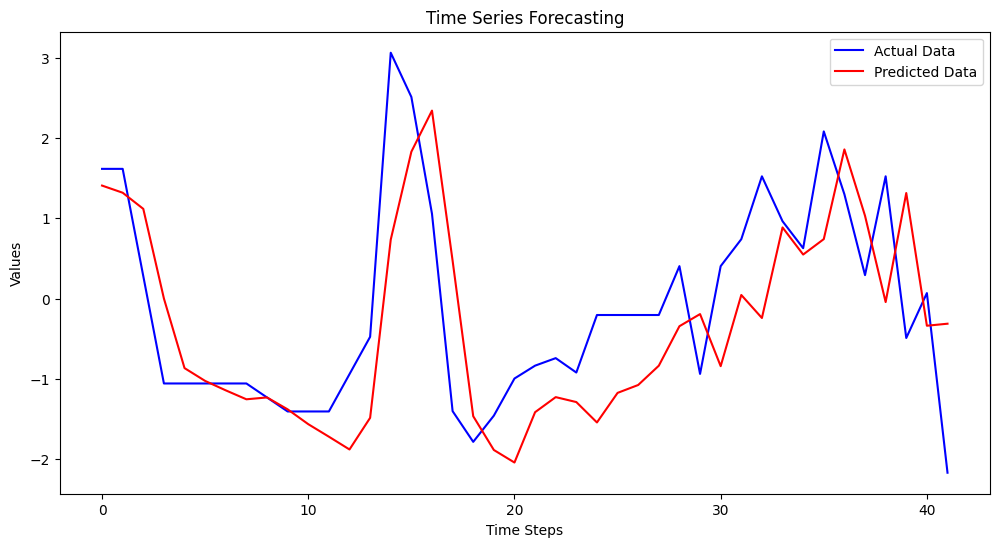

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
# Assuming predictions and true_labels are numpy arrays of the same shape
plt.figure(figsize=(12, 6))
plt.plot(true_labels[:, 0], label='Actual Data', color='blue')  # Adjust indexing based on your data shape
plt.plot(predictions[:, 0], label='Predicted Data', color='red')  # Adjust indexing based on your data shape
plt.title('Time Series Forecasting')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()

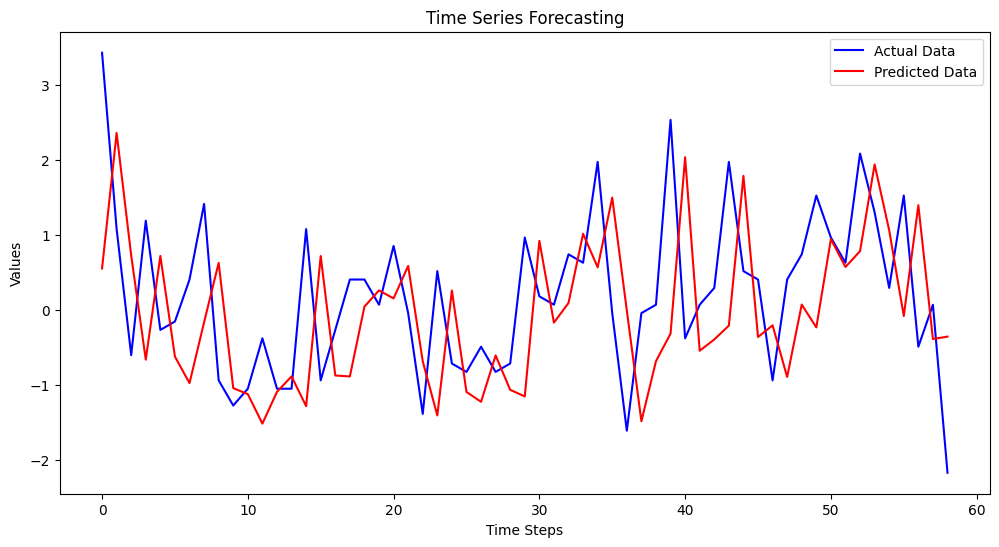

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# Assuming predictions and true_labels are numpy arrays of the same shape
plt.figure(figsize=(12, 6))
plt.plot(true_labels[predictions.shape[0]//3*2::, 0], label='Actual Data', color='blue')  # Adjust indexing based on your data shape
plt.plot(predictions[predictions.shape[0]//3*2::, 0], label='Predicted Data', color='red')  # Adjust indexing based on your data shape
plt.title('Time Series Forecasting')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()

# Scaling

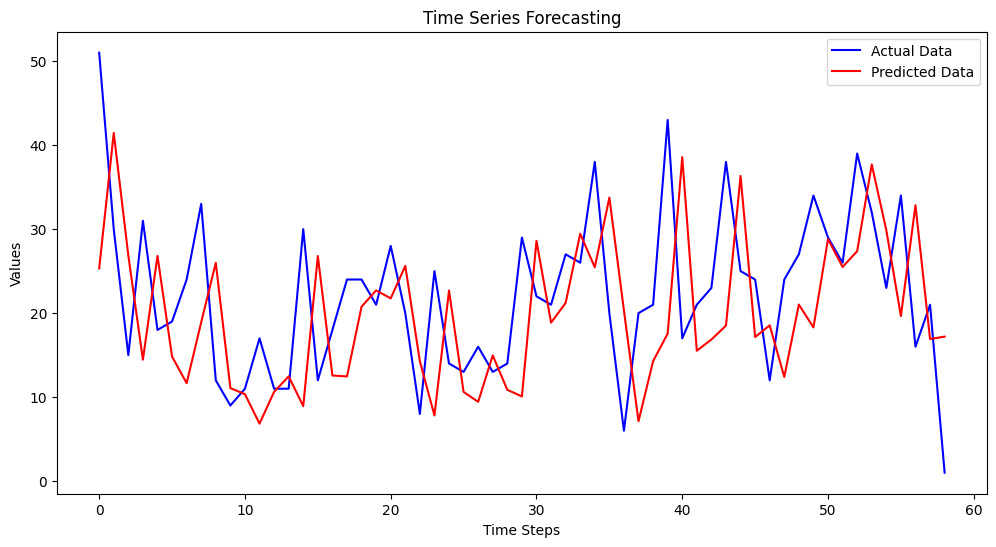

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# Assuming predictions and true_labels are numpy arrays of the same shape
plt.figure(figsize=(12, 6))
plt.plot(true_labels[59*2:, 0]*train_data.std[2] + train_data.mean[2], label='Actual Data', color='blue')  # Adjust indexing based on your data shape
plt.plot(predictions[59*2:, 0]*train_data.std[2] + train_data.mean[2], label='Predicted Data', color='red')  # Adjust indexing based on your data shape
plt.title('Time Series Forecasting')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()

# Fine tuning

In [10]:
import gc

# Store the initial learning rate separately
initial_learning_rate = args.learning_rate

for index_product in range(80):
    print("Starting fine-tuning on product {}".format(index_product))

    data = combined_dataframes[72 * index_product : 72 * (index_product + 1)]
    train_data, train_loader = data_provider(args, 'train', data)
    vali_data, vali_loader = data_provider(args, 'val', data)
    test_data, test_loader = data_provider(args, 'test', data)

    time_now = time.time()

    train_steps = len(train_loader)
    early_stopping = EarlyStopping(accelerator=accelerator, patience=args.patience)

    # Reinitialize optimizer and scheduler
    trained_parameters = [p for p in model.parameters() if p.requires_grad]
    model_optim = optim.Adam(trained_parameters, lr=initial_learning_rate)

    if args.lradj == 'COS':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(model_optim, T_max=20, eta_min=1e-8)
    else:
        scheduler = lr_scheduler.OneCycleLR(
            optimizer=model_optim,
            steps_per_epoch=train_steps,
            pct_start=args.pct_start,
            epochs=args.train_epochs,
            max_lr=initial_learning_rate,
        )

    # Prepare everything with the new optimizer and scheduler
    train_loader, vali_loader, test_loader, model, model_optim, scheduler = accelerator.prepare(
        train_loader, vali_loader, test_loader, model, model_optim, scheduler
    )

    if args.use_amp:
        scaler = torch.cuda.amp.GradScaler()

    for epoch in range(args.train_epochs):
        model.train()
        iter_count = 0
        train_loss = []
        epoch_time = time.time()

        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in tqdm(enumerate(train_loader)):
            iter_count += 1
            model_optim.zero_grad()

            batch_x = batch_x.float().to(accelerator.device)
            batch_y = batch_y.float().to(accelerator.device)
            batch_x_mark = batch_x_mark.float().to(accelerator.device)
            batch_y_mark = batch_y_mark.float().to(accelerator.device)

            # Decoder input
            dec_inp = torch.zeros_like(batch_y[:, -args.pred_len :, :]).float().to(accelerator.device)
            dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(accelerator.device)

            # Forward pass
            if args.use_amp:
                with torch.cuda.amp.autocast():
                    if args.output_attention:
                        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                    else:
                        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

                    f_dim = -1 if args.features == 'MS' else 0
                    outputs = outputs[:, -args.pred_len :, f_dim:]
                    batch_y = batch_y[:, -args.pred_len :, f_dim:]
                    loss = criterion(outputs, batch_y)
                    train_loss.append(loss.item())

                    scaler.scale(loss).backward()
                    scaler.step(model_optim)
                    scaler.update()
            else:
                with torch.cuda.amp.autocast():
                    if args.output_attention:
                        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                    else:
                        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

                    f_dim = -1 if args.features == 'MS' else 0
                    outputs = outputs[:, -args.pred_len :, f_dim:]
                    batch_y = batch_y[:, -args.pred_len :, f_dim:]
                    loss = criterion(outputs, batch_y)
                    train_loss.append(loss.item())

                accelerator.backward(loss)
                model_optim.step()

            if (i + 1) % 100 == 0:
                accelerator.print(
                    "\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item())
                )
                speed = (time.time() - time_now) / iter_count
                left_time = speed * ((args.train_epochs - epoch) * train_steps - i)
                accelerator.print(
                    "\tspeed: {:.4f}s/iter; left time: {:.4f}s".format(speed, left_time)
                )
                iter_count = 0
                time_now = time.time()

            if args.lradj == 'TST':
                adjust_learning_rate(accelerator, model_optim, scheduler, epoch + 1, args, printout=False)
                scheduler.step()

        accelerator.print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
        train_loss = np.average(train_loss)
        with torch.cuda.amp.autocast():
            vali_loss, vali_mae_loss = vali(args, accelerator, model, vali_data, vali_loader, criterion, mae_metric)
            test_loss, test_mae_loss = vali(args, accelerator, model, test_data, test_loader, criterion, mae_metric)
        accelerator.print(
            "Epoch: {0} | Train Loss: {1:.7f} Vali Loss: {2:.7f} Test Loss: {3:.7f} MAE Loss: {4:.7f}".format(
                epoch + 1, train_loss, vali_loss, test_loss, test_mae_loss
            )
        )

        if args.lradj != 'TST':
            if args.lradj == 'COS':
                scheduler.step()
                accelerator.print("lr = {:.10f}".format(model_optim.param_groups[0]["lr"]))
            else:
                if epoch == 0:
                    accelerator.print("lr = {:.10f}".format(model_optim.param_groups[0]["lr"]))
                adjust_learning_rate(accelerator, model_optim, scheduler, epoch + 1, args, printout=True)
        else:
            accelerator.print("Updating learning rate to {}".format(scheduler.get_last_lr()[0]))

    # Free up GPU memory
    del train_data, train_loader, vali_data, vali_loader, test_data, test_loader, dec_inp, batch_x, batch_y, batch_x_mark, batch_y_mark
    torch.cuda.empty_cache()
    gc.collect()

    accelerator.wait_for_everyone()
    if accelerator.is_local_main_process:
        accelerator.print("Training is done for product {}".format(index_product))

Starting fine-tuning on product 0


90it [00:12,  7.13it/s]


Epoch: 1 cost time: 12.620936632156372


45it [00:02, 15.65it/s]
42it [00:02, 15.73it/s]


Epoch: 1 | Train Loss: 0.3021652 Vali Loss: 0.5750351 Test Loss: 0.5706799 MAE Loss: 0.5728618
lr = 0.0000004000
Updating learning rate to 1e-05


90it [00:11,  7.56it/s]


Epoch: 2 cost time: 11.900231838226318


45it [00:02, 15.91it/s]
42it [00:02, 15.90it/s]


Epoch: 2 | Train Loss: 0.3358730 Vali Loss: 0.5570341 Test Loss: 0.4714026 MAE Loss: 0.5056730
Updating learning rate to 5e-06
Training is done for product 0
Starting fine-tuning on product 1


90it [00:11,  7.59it/s]


Epoch: 1 cost time: 11.857954263687134


45it [00:02, 15.46it/s]
42it [00:02, 15.49it/s]


Epoch: 1 | Train Loss: 0.6050617 Vali Loss: 0.5251672 Test Loss: 0.3112757 MAE Loss: 0.4440070
lr = 0.0000004000
Updating learning rate to 1e-05


90it [00:11,  7.71it/s]


Epoch: 2 cost time: 11.68001103401184


45it [00:02, 16.36it/s]
42it [00:02, 15.37it/s]


Epoch: 2 | Train Loss: 0.4551680 Vali Loss: 0.5620162 Test Loss: 0.3484508 MAE Loss: 0.4575181
Updating learning rate to 5e-06
Training is done for product 1
Starting fine-tuning on product 2


90it [00:11,  7.74it/s]


Epoch: 1 cost time: 11.635253429412842


45it [00:02, 16.07it/s]
42it [00:02, 16.07it/s]


Epoch: 1 | Train Loss: 0.6438113 Vali Loss: 0.5320940 Test Loss: 0.6155752 MAE Loss: 0.6582750
lr = 0.0000004000
Updating learning rate to 1e-05


90it [00:11,  7.70it/s]


Epoch: 2 cost time: 11.684273719787598


45it [00:02, 15.67it/s]
42it [00:02, 16.06it/s]


Epoch: 2 | Train Loss: 0.5737324 Vali Loss: 0.4928246 Test Loss: 0.5900801 MAE Loss: 0.6145532
Updating learning rate to 5e-06
Training is done for product 2
Starting fine-tuning on product 3


90it [00:11,  7.65it/s]


Epoch: 1 cost time: 11.77438759803772


45it [00:02, 15.73it/s]
42it [00:02, 15.42it/s]


Epoch: 1 | Train Loss: 1.0819447 Vali Loss: 1.4275753 Test Loss: 1.5839295 MAE Loss: 0.9385506
lr = 0.0000004000
Updating learning rate to 1e-05


90it [00:11,  7.59it/s]


Epoch: 2 cost time: 11.869556188583374


45it [00:02, 15.46it/s]
42it [00:02, 14.81it/s]


Epoch: 2 | Train Loss: 1.0528322 Vali Loss: 1.2668458 Test Loss: 1.4979968 MAE Loss: 0.9196337
Updating learning rate to 5e-06
Training is done for product 3
Starting fine-tuning on product 4


90it [00:11,  7.60it/s]


Epoch: 1 cost time: 11.850901365280151


45it [00:02, 15.83it/s]
42it [00:02, 15.64it/s]


Epoch: 1 | Train Loss: 0.7789604 Vali Loss: 0.5672311 Test Loss: 1.1907193 MAE Loss: 0.8215068
lr = 0.0000004000
Updating learning rate to 1e-05


90it [00:11,  7.57it/s]


Epoch: 2 cost time: 11.887428045272827


45it [00:02, 15.72it/s]
42it [00:02, 15.58it/s]


Epoch: 2 | Train Loss: 0.6707425 Vali Loss: 0.5375204 Test Loss: 1.2380720 MAE Loss: 0.8200001
Updating learning rate to 5e-06
Training is done for product 4
Starting fine-tuning on product 5


90it [00:11,  7.65it/s]


Epoch: 1 cost time: 11.773855686187744


45it [00:02, 15.73it/s]
42it [00:02, 16.14it/s]


Epoch: 1 | Train Loss: 0.3148566 Vali Loss: 3.1709470 Test Loss: 1.3716266 MAE Loss: 0.8572638
lr = 0.0000004000
Updating learning rate to 1e-05


90it [00:11,  7.81it/s]


Epoch: 2 cost time: 11.52479338645935


45it [00:02, 15.82it/s]
42it [00:02, 14.87it/s]


Epoch: 2 | Train Loss: 0.3154825 Vali Loss: 4.0643665 Test Loss: 0.9439751 MAE Loss: 0.7379633
Updating learning rate to 5e-06
Training is done for product 5
Starting fine-tuning on product 6


90it [00:11,  7.55it/s]


Epoch: 1 cost time: 11.923626184463501


45it [00:02, 15.98it/s]
42it [00:02, 15.66it/s]


Epoch: 1 | Train Loss: 0.7709743 Vali Loss: 0.8836104 Test Loss: 0.8652200 MAE Loss: 0.6970580
lr = 0.0000004000
Updating learning rate to 1e-05


90it [00:11,  7.62it/s]


Epoch: 2 cost time: 11.812066555023193


45it [00:02, 15.39it/s]
42it [00:02, 15.51it/s]


Epoch: 2 | Train Loss: 0.8172115 Vali Loss: 0.8639215 Test Loss: 0.7665299 MAE Loss: 0.6975995
Updating learning rate to 5e-06
Training is done for product 6
Starting fine-tuning on product 7


90it [00:11,  7.65it/s]


Epoch: 1 cost time: 11.77110743522644


45it [00:02, 15.11it/s]
42it [00:02, 15.55it/s]


Epoch: 1 | Train Loss: 0.2336312 Vali Loss: 0.1830044 Test Loss: 0.4696981 MAE Loss: 0.4160493
lr = 0.0000004000
Updating learning rate to 1e-05


90it [00:11,  7.62it/s]


Epoch: 2 cost time: 11.811145067214966


45it [00:02, 15.67it/s]
42it [00:02, 14.68it/s]


Epoch: 2 | Train Loss: 0.1593342 Vali Loss: 0.1561542 Test Loss: 0.5047387 MAE Loss: 0.4602711
Updating learning rate to 5e-06
Training is done for product 7
Starting fine-tuning on product 8


90it [00:11,  7.53it/s]


Epoch: 1 cost time: 11.95226526260376


45it [00:02, 15.55it/s]
42it [00:02, 15.32it/s]


Epoch: 1 | Train Loss: 0.6516167 Vali Loss: 0.7471172 Test Loss: 1.6068318 MAE Loss: 0.9375081
lr = 0.0000004000
Updating learning rate to 1e-05


90it [00:11,  7.57it/s]


Epoch: 2 cost time: 11.899693250656128


45it [00:02, 15.87it/s]
42it [00:02, 15.63it/s]


Epoch: 2 | Train Loss: 0.6858003 Vali Loss: 0.6567652 Test Loss: 1.3371384 MAE Loss: 0.8554469
Updating learning rate to 5e-06
Training is done for product 8
Starting fine-tuning on product 9


90it [00:12,  7.43it/s]


Epoch: 1 cost time: 12.111671924591064


45it [00:03, 13.55it/s]
42it [00:02, 15.29it/s]


Epoch: 1 | Train Loss: 0.7619385 Vali Loss: 1.6807088 Test Loss: 2.1296000 MAE Loss: 1.0497576
lr = 0.0000004000
Updating learning rate to 1e-05


90it [00:11,  7.60it/s]


Epoch: 2 cost time: 11.848680973052979


45it [00:02, 15.55it/s]
42it [00:02, 14.42it/s]


Epoch: 2 | Train Loss: 0.8721945 Vali Loss: 1.4965276 Test Loss: 2.0278222 MAE Loss: 1.0705652
Updating learning rate to 5e-06
Training is done for product 9
Starting fine-tuning on product 10


90it [00:11,  7.68it/s]


Epoch: 1 cost time: 11.726326704025269


45it [00:02, 16.19it/s]
42it [00:02, 16.47it/s]


Epoch: 1 | Train Loss: 0.7236023 Vali Loss: 2.0957182 Test Loss: 1.7516917 MAE Loss: 0.8880830
lr = 0.0000004000
Updating learning rate to 1e-05


90it [00:11,  7.69it/s]


Epoch: 2 cost time: 11.699802160263062


45it [00:02, 15.16it/s]
42it [00:02, 15.52it/s]


Epoch: 2 | Train Loss: 0.6837721 Vali Loss: 2.0050138 Test Loss: 2.0193213 MAE Loss: 0.9373949
Updating learning rate to 5e-06
Training is done for product 10
Starting fine-tuning on product 11


90it [00:11,  7.53it/s]


Epoch: 1 cost time: 11.95578408241272


45it [00:02, 15.25it/s]
42it [00:02, 15.65it/s]


Epoch: 1 | Train Loss: 0.3392580 Vali Loss: 1.1098087 Test Loss: 0.7420320 MAE Loss: 0.6636380
lr = 0.0000004000
Updating learning rate to 1e-05


90it [00:11,  7.50it/s]


Epoch: 2 cost time: 12.00255560874939


45it [00:02, 15.90it/s]
42it [00:02, 14.97it/s]


Epoch: 2 | Train Loss: 0.3020132 Vali Loss: 1.1477245 Test Loss: 0.6786510 MAE Loss: 0.6622980
Updating learning rate to 5e-06
Training is done for product 11
Starting fine-tuning on product 12


90it [00:11,  7.54it/s]


Epoch: 1 cost time: 11.94540286064148


45it [00:02, 15.31it/s]
42it [00:02, 14.88it/s]


Epoch: 1 | Train Loss: 0.5866206 Vali Loss: 0.8978007 Test Loss: 1.0416428 MAE Loss: 0.7723361
lr = 0.0000004000
Updating learning rate to 1e-05


90it [00:11,  7.55it/s]


Epoch: 2 cost time: 11.926419496536255


45it [00:02, 15.60it/s]
42it [00:02, 15.57it/s]


Epoch: 2 | Train Loss: 0.6510671 Vali Loss: 0.9121678 Test Loss: 1.0008588 MAE Loss: 0.7639036
Updating learning rate to 5e-06
Training is done for product 12
Starting fine-tuning on product 13


90it [00:11,  7.58it/s]


Epoch: 1 cost time: 11.879329204559326


45it [00:02, 16.12it/s]
42it [00:02, 15.90it/s]


Epoch: 1 | Train Loss: 0.5618525 Vali Loss: 3.7485495 Test Loss: 1.3538281 MAE Loss: 0.9081624
lr = 0.0000004000
Updating learning rate to 1e-05


90it [00:11,  7.62it/s]


Epoch: 2 cost time: 11.813921928405762


45it [00:02, 15.27it/s]
42it [00:02, 16.07it/s]


Epoch: 2 | Train Loss: 0.5648999 Vali Loss: 3.5047680 Test Loss: 1.3162379 MAE Loss: 0.8632978
Updating learning rate to 5e-06
Training is done for product 13
Starting fine-tuning on product 14


90it [00:11,  7.59it/s]


Epoch: 1 cost time: 11.854628801345825


45it [00:02, 16.25it/s]
42it [00:02, 15.58it/s]


Epoch: 1 | Train Loss: 0.5510903 Vali Loss: 0.5919174 Test Loss: 1.2139186 MAE Loss: 0.8059923
lr = 0.0000004000
Updating learning rate to 1e-05


90it [00:11,  7.80it/s]


Epoch: 2 cost time: 11.54117727279663


45it [00:02, 16.31it/s]
42it [00:02, 16.13it/s]


Epoch: 2 | Train Loss: 0.6041607 Vali Loss: 0.6245607 Test Loss: 1.2237259 MAE Loss: 0.8330666
Updating learning rate to 5e-06
Training is done for product 14
Starting fine-tuning on product 15


90it [00:11,  7.85it/s]


Epoch: 1 cost time: 11.471152305603027


45it [00:02, 15.85it/s]
42it [00:02, 16.46it/s]


Epoch: 1 | Train Loss: 0.6029780 Vali Loss: 0.7680648 Test Loss: 0.5065599 MAE Loss: 0.5035695
lr = 0.0000004000
Updating learning rate to 1e-05


90it [00:11,  8.04it/s]


Epoch: 2 cost time: 11.196999073028564


45it [00:02, 16.55it/s]
42it [00:02, 15.84it/s]


Epoch: 2 | Train Loss: 0.6015210 Vali Loss: 0.7222593 Test Loss: 0.5609757 MAE Loss: 0.5550033
Updating learning rate to 5e-06
Training is done for product 15
Starting fine-tuning on product 16


90it [00:11,  7.88it/s]


Epoch: 1 cost time: 11.426999568939209


45it [00:02, 15.63it/s]
42it [00:02, 15.59it/s]


Epoch: 1 | Train Loss: 0.4587296 Vali Loss: 1.0037014 Test Loss: 0.8431403 MAE Loss: 0.6790530
lr = 0.0000004000
Updating learning rate to 1e-05


90it [00:11,  7.61it/s]


Epoch: 2 cost time: 11.831965208053589


45it [00:02, 16.68it/s]
42it [00:02, 15.76it/s]


Epoch: 2 | Train Loss: 0.5711069 Vali Loss: 0.9812534 Test Loss: 0.9082528 MAE Loss: 0.7360679
Updating learning rate to 5e-06
Training is done for product 16
Starting fine-tuning on product 17


90it [00:11,  7.69it/s]


Epoch: 1 cost time: 11.713152408599854


45it [00:02, 15.69it/s]
42it [00:02, 15.70it/s]


Epoch: 1 | Train Loss: 0.4533507 Vali Loss: 0.4870885 Test Loss: 0.5371811 MAE Loss: 0.5746346
lr = 0.0000004000
Updating learning rate to 1e-05


90it [00:11,  7.69it/s]


Epoch: 2 cost time: 11.704903364181519


45it [00:02, 15.73it/s]
42it [00:02, 15.21it/s]


Epoch: 2 | Train Loss: 0.4883860 Vali Loss: 0.4862574 Test Loss: 0.5294981 MAE Loss: 0.5728919
Updating learning rate to 5e-06
Training is done for product 17
Starting fine-tuning on product 18


90it [00:11,  7.72it/s]


Epoch: 1 cost time: 11.655248165130615


45it [00:02, 16.14it/s]
42it [00:02, 15.94it/s]


Epoch: 1 | Train Loss: 0.1158764 Vali Loss: 0.1241401 Test Loss: 0.4014538 MAE Loss: 0.3394089
lr = 0.0000004000
Updating learning rate to 1e-05


90it [00:11,  7.62it/s]


Epoch: 2 cost time: 11.815428972244263


45it [00:02, 15.42it/s]
42it [00:02, 15.95it/s]


Epoch: 2 | Train Loss: 0.0848002 Vali Loss: 0.1303376 Test Loss: 0.4104515 MAE Loss: 0.3240068
Updating learning rate to 5e-06
Training is done for product 18
Starting fine-tuning on product 19


90it [00:11,  7.73it/s]


Epoch: 1 cost time: 11.65242338180542


45it [00:02, 15.17it/s]
42it [00:02, 15.45it/s]


Epoch: 1 | Train Loss: 0.3838637 Vali Loss: 0.5032927 Test Loss: 0.8107802 MAE Loss: 0.6499568
lr = 0.0000004000
Updating learning rate to 1e-05


90it [00:11,  7.70it/s]


Epoch: 2 cost time: 11.693331956863403


45it [00:02, 16.03it/s]
42it [00:02, 15.66it/s]


Epoch: 2 | Train Loss: 0.3697420 Vali Loss: 0.4908922 Test Loss: 0.8307201 MAE Loss: 0.6343555
Updating learning rate to 5e-06
Training is done for product 19
Starting fine-tuning on product 20


90it [00:11,  7.76it/s]


Epoch: 1 cost time: 11.597599267959595


45it [00:02, 16.55it/s]
42it [00:02, 16.08it/s]


Epoch: 1 | Train Loss: 0.3001787 Vali Loss: 0.6158297 Test Loss: 0.8696969 MAE Loss: 0.7157318
lr = 0.0000004000
Updating learning rate to 1e-05


90it [00:11,  7.82it/s]


Epoch: 2 cost time: 11.510258197784424


45it [00:02, 15.57it/s]
42it [00:02, 15.60it/s]


Epoch: 2 | Train Loss: 0.2507437 Vali Loss: 0.5937429 Test Loss: 0.7809963 MAE Loss: 0.6700055
Updating learning rate to 5e-06
Training is done for product 20
Starting fine-tuning on product 21


90it [00:11,  7.69it/s]


Epoch: 1 cost time: 11.714248895645142


45it [00:02, 16.05it/s]
42it [00:02, 15.37it/s]


Epoch: 1 | Train Loss: 0.6438234 Vali Loss: 0.8093957 Test Loss: 0.7328902 MAE Loss: 0.6468167
lr = 0.0000004000
Updating learning rate to 1e-05


90it [00:11,  7.76it/s]


Epoch: 2 cost time: 11.59711217880249


45it [00:02, 16.10it/s]
42it [00:02, 15.71it/s]


Epoch: 2 | Train Loss: 0.5860953 Vali Loss: 0.8112718 Test Loss: 0.7396053 MAE Loss: 0.6449525
Updating learning rate to 5e-06
Training is done for product 21
Starting fine-tuning on product 22


90it [00:11,  7.61it/s]


Epoch: 1 cost time: 11.83125376701355


45it [00:02, 15.78it/s]
42it [00:02, 15.90it/s]


Epoch: 1 | Train Loss: 0.5270615 Vali Loss: 0.2860427 Test Loss: 0.7330661 MAE Loss: 0.6475949
lr = 0.0000004000
Updating learning rate to 1e-05


90it [00:11,  7.74it/s]


Epoch: 2 cost time: 11.633349418640137


45it [00:02, 15.54it/s]
42it [00:02, 15.72it/s]


Epoch: 2 | Train Loss: 0.6335200 Vali Loss: 0.4035562 Test Loss: 0.7353702 MAE Loss: 0.6885361
Updating learning rate to 5e-06
Training is done for product 22
Starting fine-tuning on product 23


90it [00:11,  7.59it/s]


Epoch: 1 cost time: 11.853064775466919


45it [00:02, 15.82it/s]
42it [00:02, 15.52it/s]


Epoch: 1 | Train Loss: 0.5748494 Vali Loss: 0.7175761 Test Loss: 0.8169937 MAE Loss: 0.7009836
lr = 0.0000004000
Updating learning rate to 1e-05


90it [00:11,  7.75it/s]


Epoch: 2 cost time: 11.622432470321655


45it [00:02, 15.72it/s]
42it [00:02, 15.74it/s]


Epoch: 2 | Train Loss: 0.4801278 Vali Loss: 0.7523645 Test Loss: 0.8313823 MAE Loss: 0.7392380
Updating learning rate to 5e-06
Training is done for product 23
Starting fine-tuning on product 24


90it [00:11,  7.58it/s]


Epoch: 1 cost time: 11.876414775848389


45it [00:02, 15.64it/s]
42it [00:02, 15.85it/s]


Epoch: 1 | Train Loss: 0.6293876 Vali Loss: 0.3184006 Test Loss: 1.2513714 MAE Loss: 0.7600166
lr = 0.0000004000
Updating learning rate to 1e-05


90it [00:11,  7.74it/s]


Epoch: 2 cost time: 11.629681825637817


45it [00:02, 16.14it/s]
42it [00:02, 16.42it/s]


Epoch: 2 | Train Loss: 0.5860317 Vali Loss: 0.3531811 Test Loss: 1.2075719 MAE Loss: 0.7370705
Updating learning rate to 5e-06
Training is done for product 24
Starting fine-tuning on product 25


90it [00:14,  6.05it/s]


Epoch: 1 cost time: 14.880966663360596


45it [00:02, 15.78it/s]
42it [00:02, 15.93it/s]


Epoch: 1 | Train Loss: 0.2837346 Vali Loss: 0.7107747 Test Loss: 0.6523992 MAE Loss: 0.6177060
lr = 0.0000004000
Updating learning rate to 1e-05


90it [00:15,  5.85it/s]


Epoch: 2 cost time: 15.40059208869934


45it [00:02, 15.21it/s]
42it [00:02, 15.60it/s]


Epoch: 2 | Train Loss: 0.2495380 Vali Loss: 0.7095626 Test Loss: 0.6284759 MAE Loss: 0.6090244
Updating learning rate to 5e-06
Training is done for product 25
Starting fine-tuning on product 26


1it [00:00,  1.49it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 